/opt/conda/lib/python3.12/site-packages/pyfolio/plotting.py:670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.995%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  perf_stats.loc[stat, column] = str(np.round(value * 100, 3)) + "%"


Start date,2001-01-02
End date,2024-12-31
Total months,287
,Backtest
Annual return,7.995%
Cumulative returns,531.239%
Annual volatility,18.976%
Sharpe ratio,0.50
Calmar ratio,0.14
Stability,0.94
Max drawdown,-57.306%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,57.31,2007-12-10,2009-03-09,2012-10-18,1269
1,39.00,2001-01-02,2002-10-09,2004-11-24,1017
2,28.37,2020-02-19,2020-03-23,2020-06-05,78
3,22.96,2021-08-23,2022-09-30,2024-03-21,674
4,18.36,2018-10-03,2018-12-24,2019-07-12,203


/opt/conda/lib/python3.12/site-packages/pyfolio/plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


Stress Events,mean,min,max
Lehman,-0.21%,-8.40%,5.09%
9/11,0.07%,-2.33%,2.51%
US downgrade/European Debt Crisis,0.02%,-4.61%,4.84%
Fukushima,0.12%,-1.55%,1.50%
US Housing,-0.35%,-2.48%,1.84%
EZB IR Event,-0.00%,-0.83%,1.40%
Aug07,0.06%,-2.20%,1.87%
Mar08,0.19%,-2.32%,3.03%
Sept08,-0.43%,-8.40%,5.09%
2009Q1,-0.35%,-5.51%,5.20%


Top 10 long positions of all time,max
sid,
AXP,15.08%
BA,13.24%
JPM,13.23%
AAPL,12.93%
CSCO,12.89%
WMT,12.51%
TRV,12.48%
GS,12.31%
CAT,12.24%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
AXP,15.08%
BA,13.24%
JPM,13.23%
AAPL,12.93%
CSCO,12.89%
WMT,12.51%
TRV,12.48%
GS,12.31%
CAT,12.24%


/opt/conda/lib/python3.12/site-packages/pyfolio/pos.py:100: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  longs = expos.where(expos.applymap(lambda x: x > 0))
/opt/conda/lib/python3.12/site-packages/pyfolio/pos.py:101: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  shorts = expos.where(expos.applymap(lambda x: x < 0))
/opt/conda/lib/python3.12/site-packages/pyfolio/plotting.py:323: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_holdings_by_month = df_holdings.resample("1M").mean()
/opt/conda/lib/python3.12/site-packages/pyfolio/plotting.py:1465: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_turnover_by_month = df_turnover.resample("M").mean()


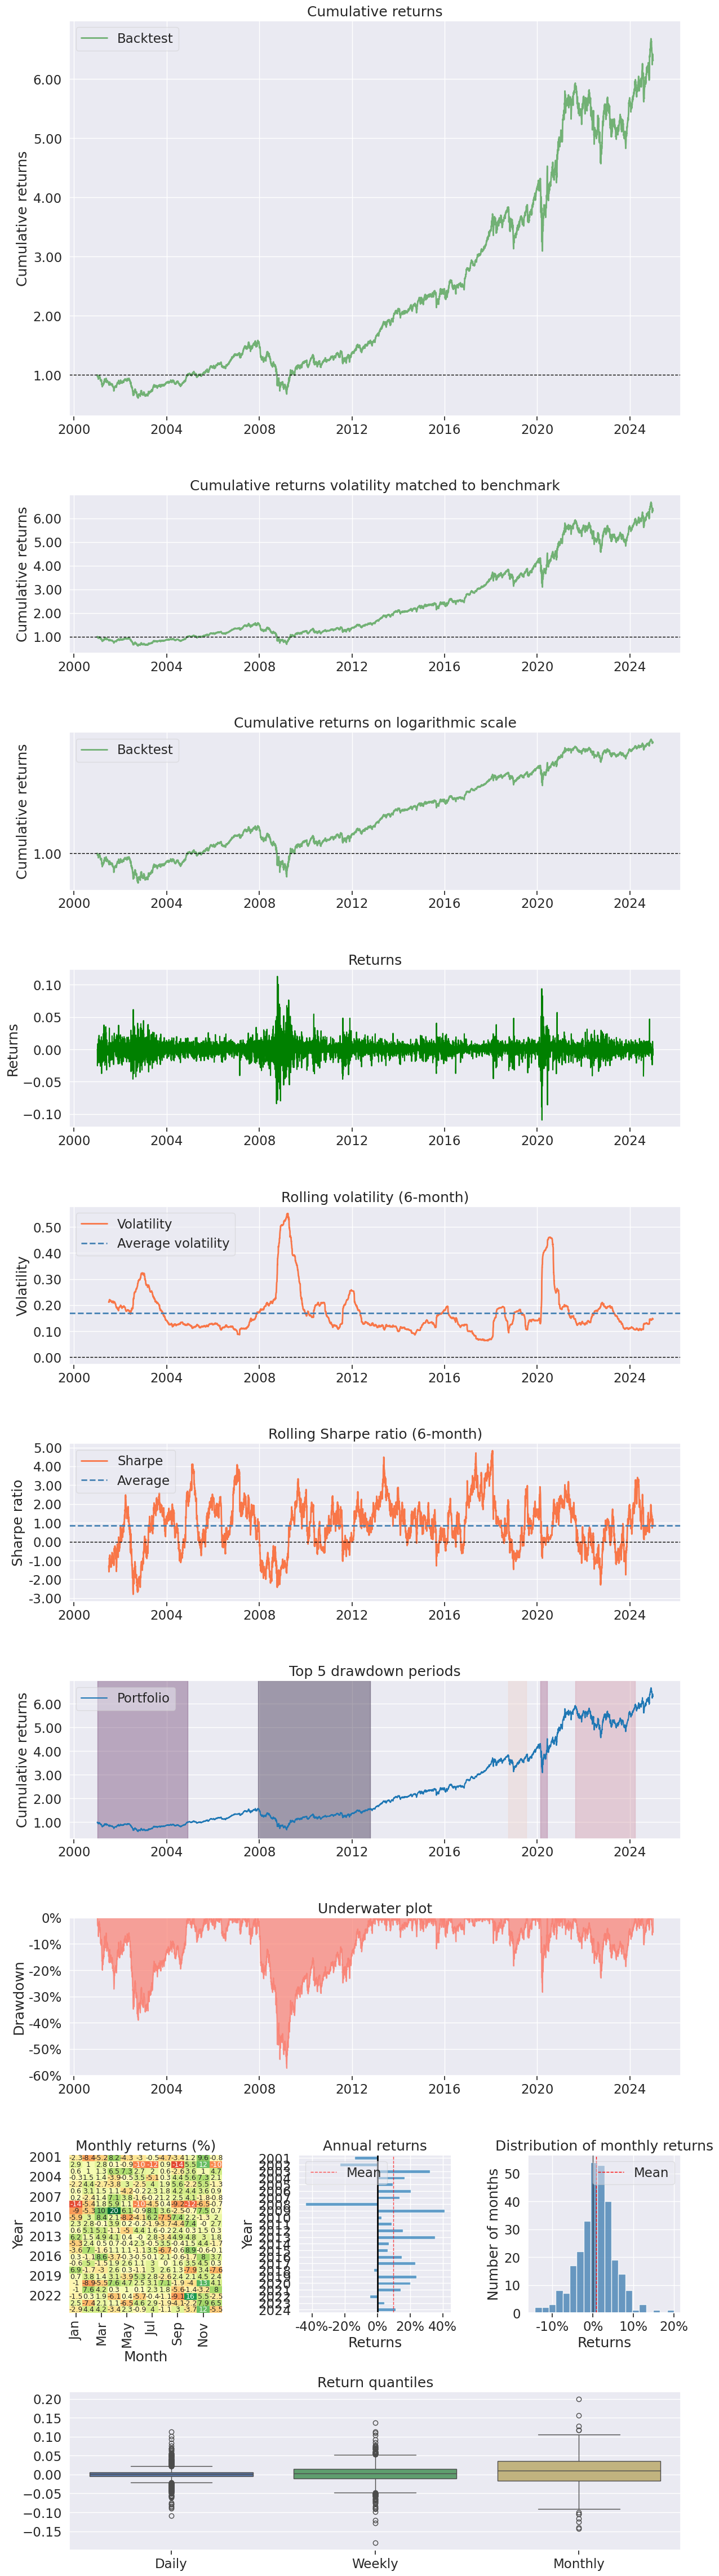

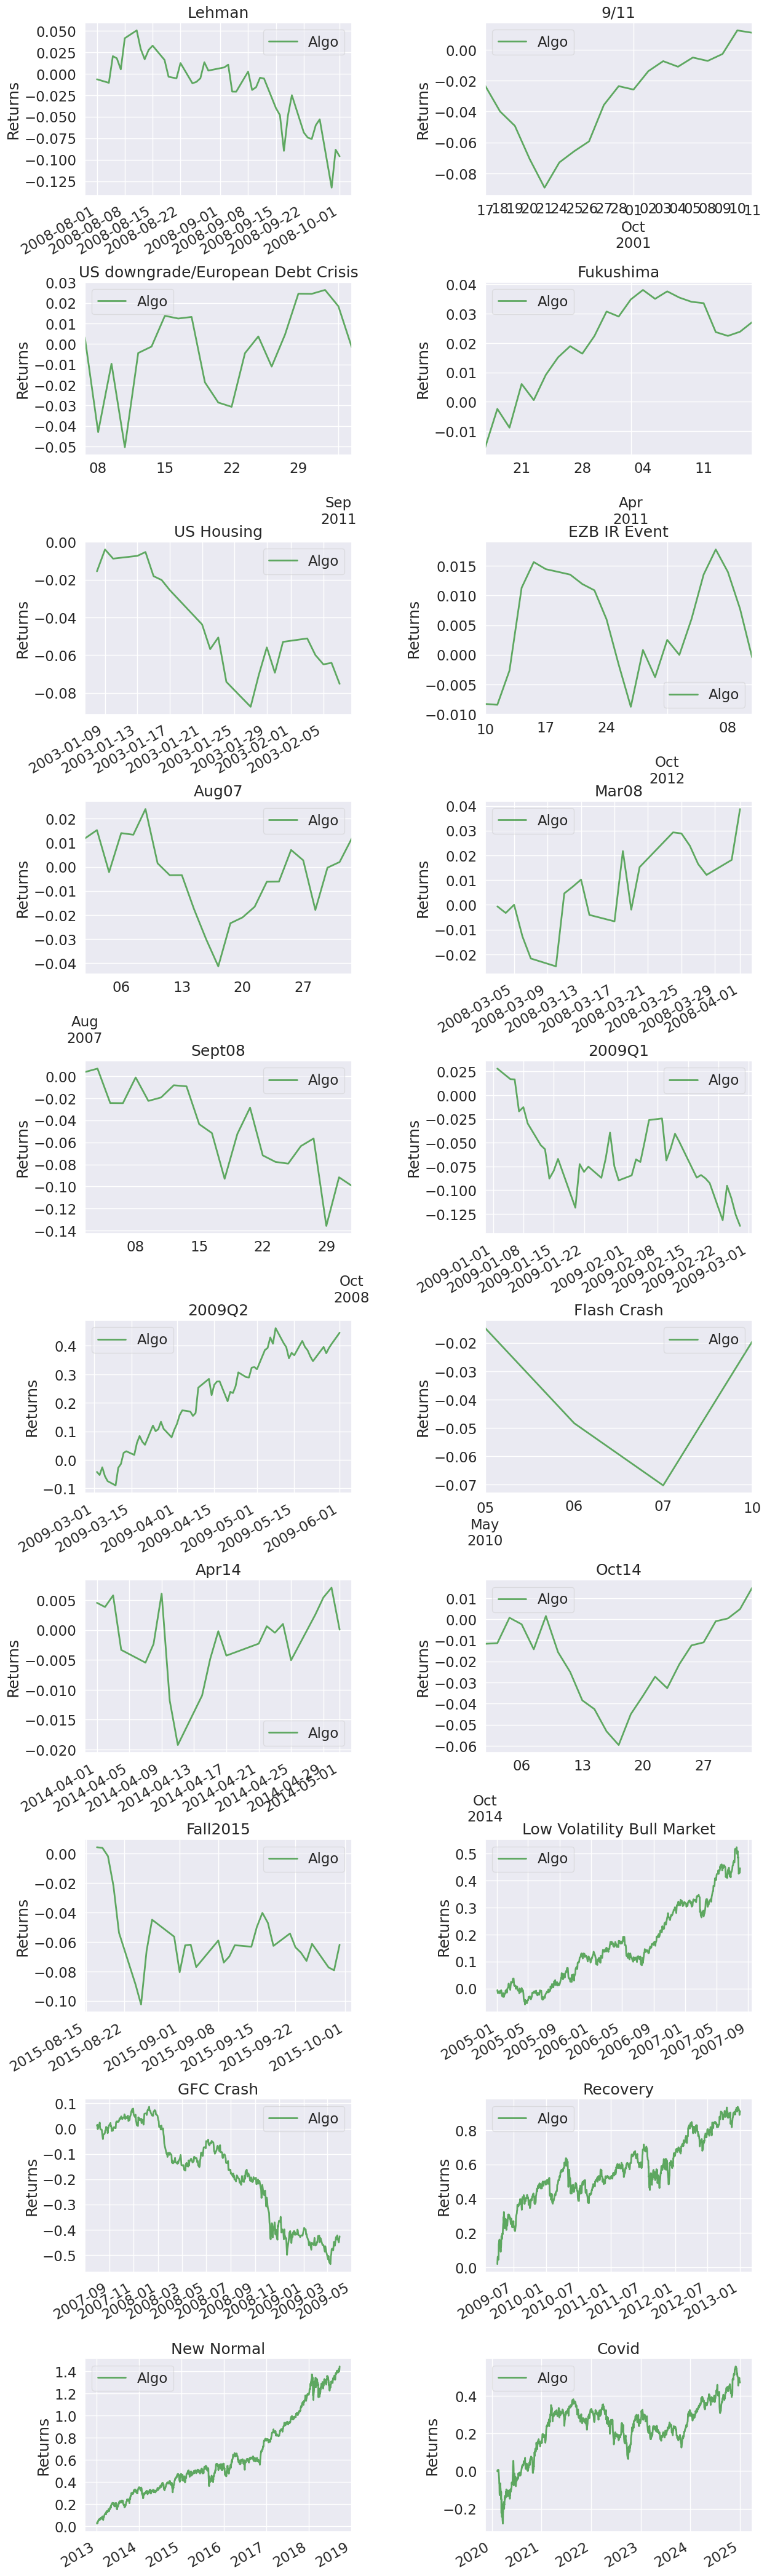

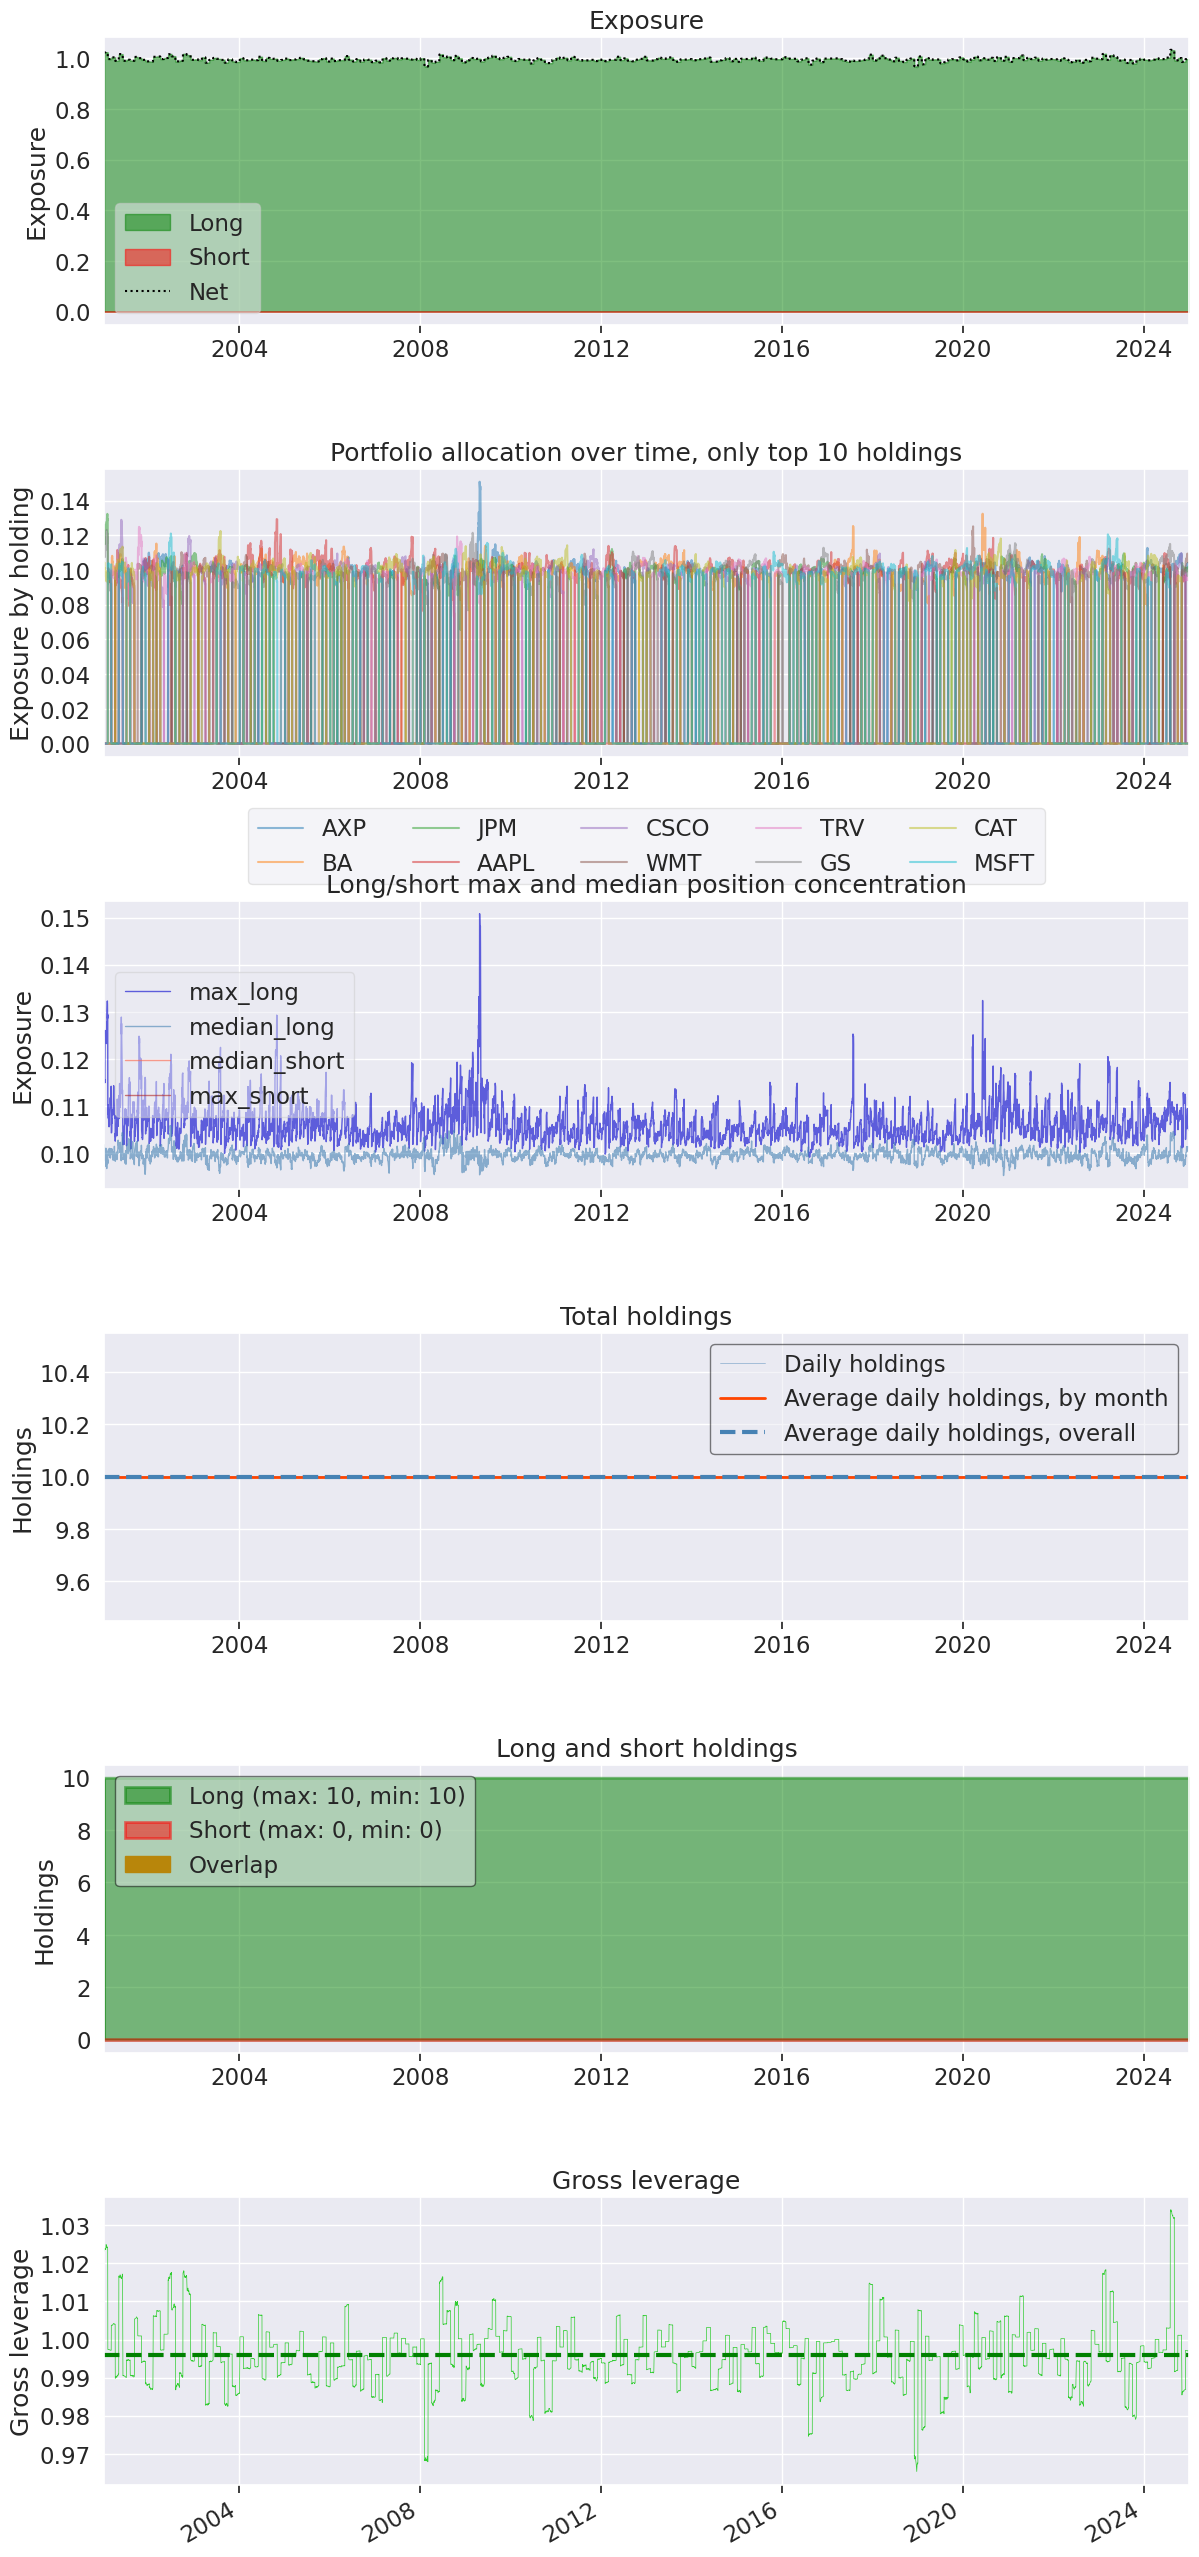

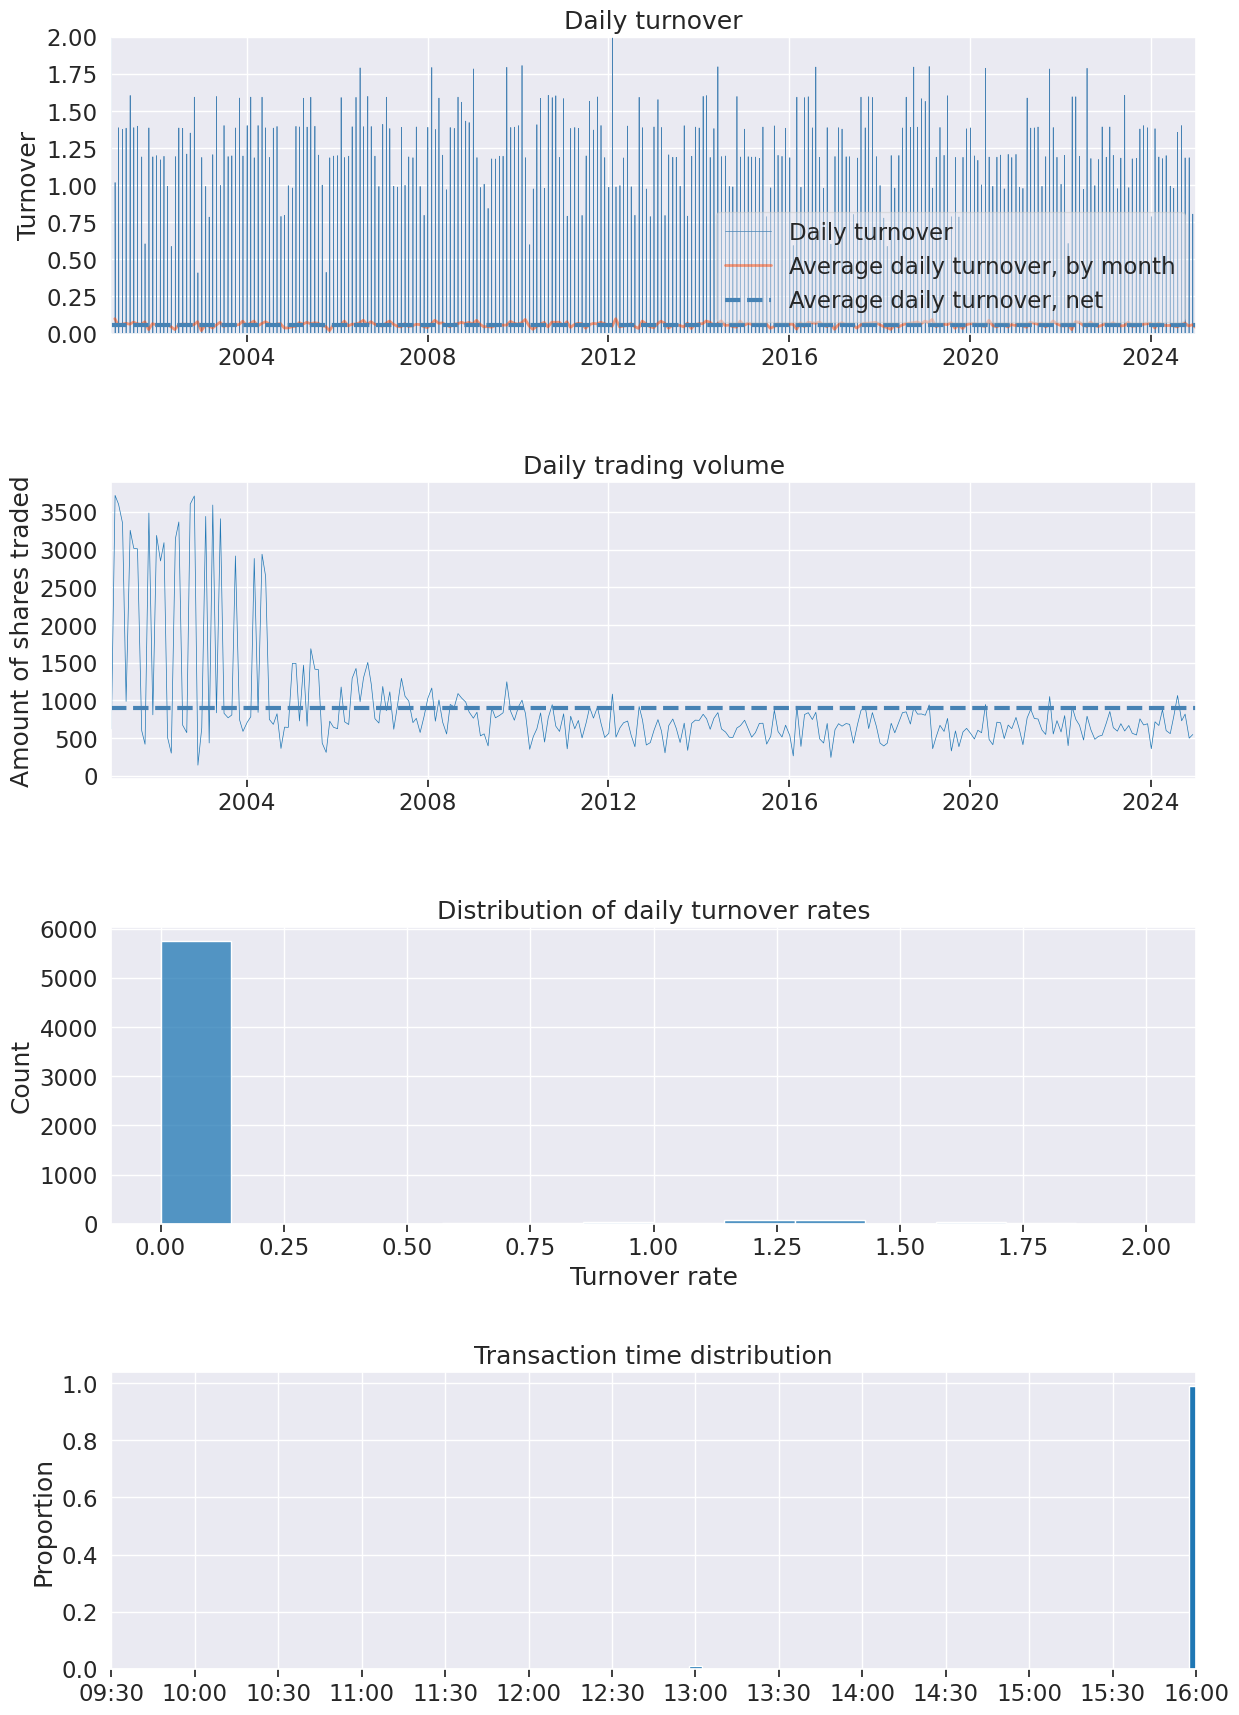

In [6]:
from zipline import run_algorithm
from zipline.api import order_target_percent, symbol
from zipline.api import schedule_function, date_rules, time_rules

from zipline.typing import ZiplineContext

import pandas as pd
import pyfolio as pf


def initialize(context: ZiplineContext):
    # which stocks to trade
    dji = [
        "AAPL",
        "AXP",
        "BA",
        "CAT",
        "CSCO",
        "CVX",
        "DIS",
        # "DWDP",
        "GS",
        "HD",
        "IBM",
        "INTC",
        "JNJ",
        "JPM",
        "KO",
        "MCD",
        "MMM",
        "MRK",
        "MSFT",
        "NKE",
        "PFE",
        "PG",
        "TRV",
        "UNH",
        # "UTX",
        "V",
        "VZ",
        "WMT",
        "XOM",
    ]
    # make symbol list from tickers
    context.stocks = [symbol(s) for s in dji]

    # set trading params
    context.history_window = 20
    context.stocks_to_hold = 10

    # schedule the daily trading routine for once per month
    schedule_function(
        func=handle_data,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_close()
    )


def month_perf(x: pd.Series):
    perf = (x.iloc[-1] / x.iloc[0]) - 1
    return perf


def handle_data(context: ZiplineContext, data: pd.DataFrame):
    # get historical data
    hist: pd.DataFrame = data.history(
        context.stocks, "close", context.history_window, "1d"
    )

    # this creates a table of percent changes, in order.
    perf_table: pd.Series = hist.apply(month_perf).sort_values(ascending=False)

    # make buy list of the top N stocks
    buy_list: pd.Series = perf_table.iloc[:context.stocks_to_hold]

    # the rest will not be held
    the_rest: pd.Series = perf_table.iloc[context.stocks_to_hold:]

    # place target buy orders for top N stocks
    for stock, perf in buy_list.items():
        stock_weight = 1 / context.stocks_to_hold
        # place order
        if data.can_trade(stock):
            order_target_percent(stock, stock_weight)

    # make sure we are flat the rest
    for stock, perf in the_rest.items():
        if data.can_trade(stock):
            order_target_percent(stock, 0.0)


def analyze(context, perf):
    # Use PyFolio to generate a performance report
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions)


if __name__ == "__main__":
    start = pd.Timestamp("2001-01-01")
    end = pd.Timestamp("2025-01-01")

    run_algorithm(
        start=start,
        end=end,
        initialize=initialize,
        analyze=analyze,
        capital_base=10000,
        data_frequency="daily",
        bundle="us_equities",
    )
